In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime

### Extract date



In [2]:
url = 'https://www.moh.gov.sg/2019-ncov-wuhan'

content = requests.get(url).content
soup =BeautifulSoup(content, 'lxml')

In [3]:
data = soup.findAll(text=re.compile("Case Summary in Singapore \(as of .+"))


In [4]:
data

['Case Summary in Singapore (as of 13 Feb 2020, 1200h)']

In [5]:
m = re.search("(\d\d \w+ 202\d, \d+\d+h)", data[0])
date_time_str = m.group(1)
data_date_time = datetime.strptime(date_time_str, '%d %b %Y, %H%Mh').strftime('%Y-%m-%d')
data_date_time


'2020-02-13'

### Extract Dataframes

In [6]:
dfs = pd.read_html(url)

In [7]:
dfs

[                            0    1
 0             Confirmed cases   58
 1       Cases tested negative  711
 2  Cases pending test results   82
 3                  Discharged   15,                0       1
 0  DORSCON Level  Orange,              0                                                  1
 0         Date                                              Title
 1  14 Feb 2020  Additional Pre-emptive Measures To Reduce Risk...
 2  14 Feb 2020  Corrections and clarifications regarding false...
 3  14 Feb 2020  Transcript of Minister for Defence, Dr Ng Eng ...
 4  13 Feb 2020  Supporting Healthcare Workers Whose Leave and ...
 5  13 Feb 2020  Two Work Passes Revoked for Re-Entry into Sing...,                0                                    1
 0         Global         46,997* confirmed(1,826 new)
 1          China          46,550 confirmed(1,820 new)
 2  Outside China  447 confirmed(6 new)in 24 countries,                 0          1
 0           China  Very High
 1  Regional Level 

In [8]:
# Look for df with confirmed cases, tested negative, ...

for df in dfs:
    combined_fields = df[0].to_string().lower()
    if "confirmed cases" in combined_fields and "cases tested" in combined_fields:
        sing_cases_df = df
        
sing_cases_df

,0,1
0,Confirmed cases,58
1,Cases tested negative,711
2,Cases pending test results,82
3,Discharged,15


In [9]:
# cleanup to make sure they are numbers

sing_cases_df[1] = sing_cases_df[1].apply(lambda x: re.sub(r'[^\d]+', '', str(x)))
sing_cases_df

,0,1
0,Confirmed cases,58
1,Cases tested negative,711
2,Cases pending test results,82
3,Discharged,15


In [10]:

# flip the table around
sing_cases_df = sing_cases_df.set_index(0).T

sing_cases_df

,Confirmed cases,Cases tested negative,Cases pending test results,Discharged
1,58,711,82,15


In [11]:
# column name mapping
old_new_map= {'confirmed': 'confirmed', 
           'negative': 'negative',
           'pending': 'pending',
           'discharged':'discharged'}
def map_name(old_name):
    for k,v in old_new_map.items():
        if k in old_name.lower():
            return v
    return None
    
sing_cases_df.columns = sing_cases_df.columns.map(map_name)
sing_cases_df.insert(0, 'datetime', data_date_time)

df = sing_cases_df
df

,datetime,confirmed,negative,pending,discharged
1,2020-02-13,58,711,82,15


### Save to file

In [12]:
from pathlib import Path
csv_file = 'data/singapore-cases.csv'

if Path(csv_file).exists():
    # read out the old data
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['datetime'], inplace=True)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [13]:
df.sort_values(by=['datetime'], inplace=True)
df.to_csv(csv_file, index=False)
df

,confirmed,datetime,discharged,negative,pending
0,18,2020-02-02,NaN,240,43
1,24,2020-02-03,NaN,262,32
2,24,2020-02-04,NaN,289,20
3,28,2020-02-05,NaN,295,62
4,33,2020-02-06,NaN,310,147
5,33,2020-02-07,NaN,363,181
6,40,2020-02-08,NaN,438,181
7,45,2020-02-09,7,581,39
8,45,2020-02-10,7,581,39
9,47,2020-02-11,9,608,43


### Plot graph

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

png_file = 'images/singapore-cases.png'
# convert to pd.datetime
df['datetime_idx'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d")

df.set_index('datetime_idx', inplace=True)



In [15]:
df

,confirmed,datetime,discharged,negative,pending
datetime_idx,,,,,
2020-02-02,18,2020-02-02,NaN,240,43
2020-02-03,24,2020-02-03,NaN,262,32
2020-02-04,24,2020-02-04,NaN,289,20
2020-02-05,28,2020-02-05,NaN,295,62
2020-02-06,33,2020-02-06,NaN,310,147
2020-02-07,33,2020-02-07,NaN,363,181
2020-02-08,40,2020-02-08,NaN,438,181
2020-02-09,45,2020-02-09,7,581,39
2020-02-10,45,2020-02-10,7,581,39


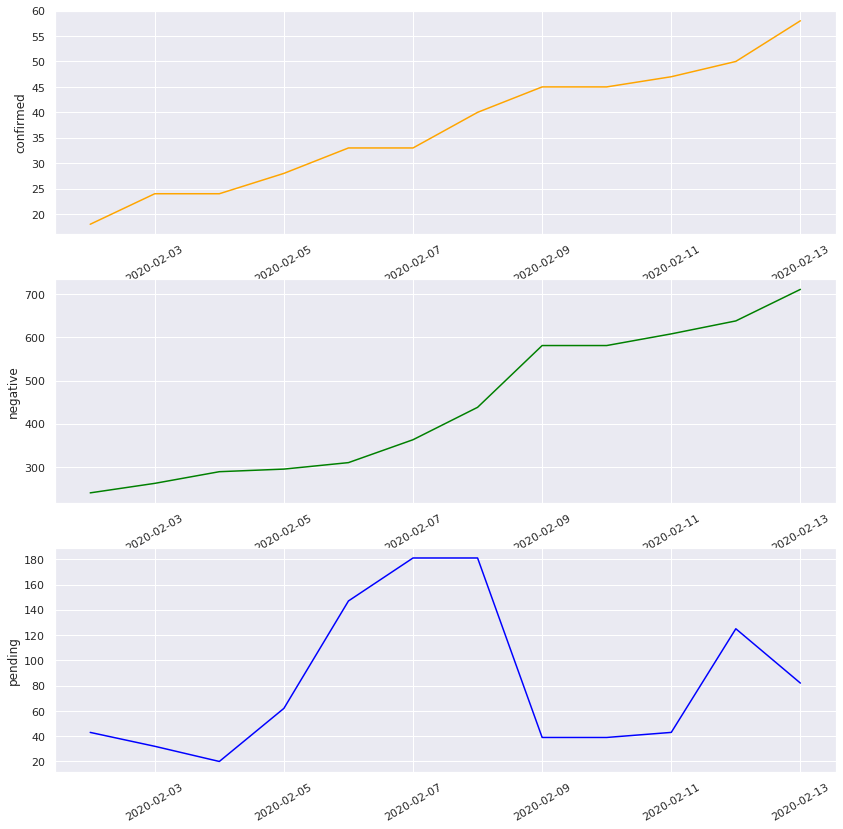

In [16]:
sns.set(rc={'figure.figsize':(14,14)})

fig, axs = plt.subplots(nrows=3)

sns.lineplot(x=df.index, y = 'confirmed', data=df, ax= axs[0], estimator=None, color='orange')
sns.lineplot(x=df.index, y = 'negative', data=df, ax= axs[1], estimator=None, color='green')
sns.lineplot(x=df.index, y = 'pending', data=df, ax= axs[2], estimator=None, color='blue')

for ax in axs:
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=30)



In [17]:
fig.savefig(png_file)